In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# Read in the data from health records survey as a raw table
hrec06 = Table.read_table("./hrsextract06.csv")

In [3]:
# the raw table - pretty yechy
hrec06

hhidpn,r8agey_m,ragender,raracem,rahispan,raedyrs,h8cpl,h8atota,rayshlt,r8shlt,r8expyrs,r8cesd,r8bpavgs,r8bpavgp,r8smoken,r8mdactx,r8weightbio,r8weight,r8heightbio,r8height
3010,70,1,1,0,12,1,914000,3,3,21.5,0,140,58,0,4,74.1623,71.6672,1.64465,1.6256
3020,67,2,1,0,16,1,914000,1,3,23.7,0,139,72,0,1,66.9048,65.317,1.61925,1.6256
10003030,50,2,1,0,16,0,12000,3,5,47.5,4,124,98,0,2,64.4101,58.9667,1.5494,1.5748
10004010,66,1,1,0,16,1,1.832e+06,1,4,7,1,130,74,0,2,101.605,102.511,1.8415,1.8542
10004040,60,2,1,0,12,1,1.832e+06,1,2,28.25,0,125,67,0,2,77.3374,77.1103,1.6383,1.651
10013010,68,1,1,0,12,0,50,1,3,16.5,2,125,67,0,5,110.223,108.862,1.7272,1.7272
10038010,70,1,1,0,16,1,2.5e+06,2,2,22.5,1,107,52,0,2,73.4819,74.8423,1.70815,1.7526
10038040,63,2,1,0,16,1,2.5e+06,1,1,27.05,1,112,70,0,2,65.3173,64.4098,1.67005,1.6764
10050010,64,2,3,0,17,0,664066,1,2,27.025,1,136,90,0,5,75.9767,68.0385,1.5875,1.6256
10059020,70,2,1,0,16,1,1.2405e+07,2,3,19.5,0,112,54,1,2,58.967,57.6059,1.6637,1.6764


In [4]:
# Create a table that provides the mapping and decoding to a more readable form
health_map = Table.from_rows(
    [["hhidpn",  "id", None, "identifier"],
    ["r8agey_m", "age", None, "age in years in wave 8"],
    ["ragender", "gender", ['male','female'], "1 = male,  2 = female)"],
    ["raracem",  "race",   ['white','black','other'], "(1 = white,  2 = black,  3 = other)"],
    ["rahispan", "hispanic",  None, "(1 = yes)"],
    ["raedyrs",  "education", None, "education in years"],
    ["h8cpl",    "couple",    None, "in a couple household (1 = yes)"],
    ["r8bpavgs", "blood pressure", None,"average systolic BP"],
    ["r8bpavgp", "pulse", None, "average pulse"],
    ["r8smoken", "smoker",None, "currently smokes cigarettes"],
    ["r8mdactx", "exercise", None, "frequency of moderate exercise (1=everyday, 2=>1perweek, 3=1perweek, 4=1-3permonth\
, 5=never)"],
    ["r8weightbio", "weight", None, "objective weight in kg"],
    ["r8heightbio","height", None, "objective height in m"],
    ], 
    ["raw label", "label", "encoding", "Description"])
health_map

raw label,label,encoding,Description
hhidpn,id,None,identifier
r8agey_m,age,None,age in years in wave 8
ragender,gender,"['male', 'female']","1 = male, 2 = female)"
raracem,race,"['white', 'black', 'other']","(1 = white, 2 = black, 3 = other)"
rahispan,hispanic,None,(1 = yes)
raedyrs,education,None,education in years
h8cpl,couple,None,in a couple household (1 = yes)
r8bpavgs,blood pressure,None,average systolic BP
r8bpavgp,pulse,None,average pulse
r8smoken,smoker,None,currently smokes cigarettes


In [5]:
def table_lookup(table,key_col,key,map_col):
    row = np.where(table[key_col]==key)
    if len(row[0]) == 1:
        return table[map_col][row[0]][0]
    else:
        return -1

In [6]:
def map_raw_table(raw_table,map_table):
    mapped = Table()
    for raw_label in raw_table :
        if raw_label in map_table["raw label"] :
            new_label = table_lookup(map_table,'raw label',raw_label,'label')
            encoding = table_lookup(map_table,'raw label',raw_label,'encoding')
            if encoding is None :
                mapped[new_label] = raw_table[raw_label]
            else:
                mapped[new_label] = raw_table.apply(lambda x: encoding[x-1], raw_label)
    return mapped

In [12]:
# create a more usable table by mapping the raw to finished
health = map_raw_table(hrec06,health_map)
health

id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
3010,70,male,white,0,12,1,140,58,0,4,74.1623,1.64465
3020,67,female,white,0,16,1,139,72,0,1,66.9048,1.61925
10003030,50,female,white,0,16,0,124,98,0,2,64.4101,1.5494
10004010,66,male,white,0,16,1,130,74,0,2,101.605,1.8415
10004040,60,female,white,0,12,1,125,67,0,2,77.3374,1.6383
10013010,68,male,white,0,12,0,125,67,0,5,110.223,1.7272
10038010,70,male,white,0,16,1,107,52,0,2,73.4819,1.70815
10038040,63,female,white,0,16,1,112,70,0,2,65.3173,1.67005
10050010,64,female,other,0,17,0,136,90,0,5,75.9767,1.5875
10059020,70,female,white,0,16,1,112,54,1,2,58.967,1.6637


In [13]:
def firstQtile(x) : return np.percentile(x,25)
def thirdQtile(x) : return np.percentile(x,25)
summary_ops = (min, firstQtile, np.median, np.mean, thirdQtile, max, sum)

In [14]:
# Let's try what is the effect of smoking
smokers = health.where('smoker',1)
nosmokers = health.where('smoker',0)
print(smokers.num_rows, ' smokers')
print(nosmokers.num_rows, ' non-smokers')

893  smokers
5449  non-smokers


In [15]:
smokers.stats(summary_ops)

statistic,id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
min,1.0059e+07,30,female,black,0,0,0,68,45,1,1,36.0606,1.4224
firstQtile,4.8508e+07,55,,,0,11,0,114,66,1,2,64.1833,1.6002
median,1.15627e+08,62,,,0,12,1,129,74,1,3,75.2963,1.67005
mean,1.98972e+08,62.0728,,,0.0615901,12.1299,0.62598,130.354,74.5801,1,2.98768,76.7292,1.67348
thirdQtile,4.8508e+07,55,,,0,11,0,114,66,1,2,64.1833,1.6002
max,5.02753e+08,87,male,white,1,17,1,217,119,1,5,134.263,1.9685
sum,1.77682e+11,55431,,,55,10832,559,116406,66600,893,2668,68519.2,1494.42


In [16]:
nosmokers.stats(summary_ops)

statistic,id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
min,3010,31,female,black,0,0,0,79,34,0,1,32.205,1.36525
firstQtile,4.5397e+07,60,,,0,12,0,117,62,0,2,68.0388,1.5875
median,1.10427e+08,68,,,0,12,1,129,69,0,2,79.6054,1.65735
mean,1.65713e+08,67.4986,,,0.073408,12.9648,0.715728,130.934,69.4542,0,2.69114,81.2584,1.66315
thirdQtile,4.5397e+07,60,,,0,12,0,117,62,0,2,68.0388,1.5875
max,5.02759e+08,90,male,white,1,17,1,224,133,0,5,137.892,1.96215
sum,9.02972e+11,367800,,,400,70645,3900,713462,378456,0,14664,442777,9062.52


It would appear that nosmokers are older, better educated, and heavier - but of similar height and blood pressure

In [21]:
# Lets draw two samples of equal size
n_sample = 200
smoker_sample = smokers.sample(n_sample)
nosmoker_sample = nosmokers.sample(n_sample)

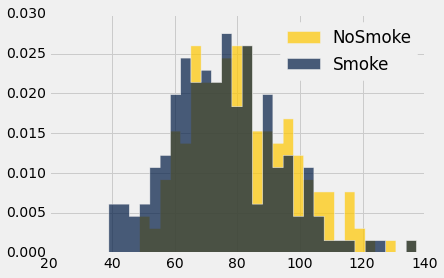

In [22]:
weight = Table([nosmoker_sample['weight'],smoker_sample['weight']],['NoSmoke','Smoke'])
weight.hist(overlay=True,bins=30,normed=True)

In [23]:
bins=np.arange(39,139,5)
weight_dist = weight.bin(bins=bins, normed=True)
weight_dist['diff']=weight_dist['NoSmoke density']-weight_dist['Smoke density']
print('TVD: ',sum(np.abs(weight_dist['diff'])))
weight_dist.show()

TVD:  0.0562814070352


bin,NoSmoke density,Smoke density,diff
39,0,0.00603015,-0.00603015
44,0.00100503,0.00502513,-0.0040201
49,0.00301508,0.0080402,-0.00502513
54,0.00904523,0.0120603,-0.00301508
59,0.0140704,0.0201005,-0.00603015
64,0.0221106,0.0251256,-0.00301508
69,0.0221106,0.0221106,0
74,0.0241206,0.0241206,0
79,0.0281407,0.0221106,0.00603015
84,0.0150754,0.0120603,0.00301508


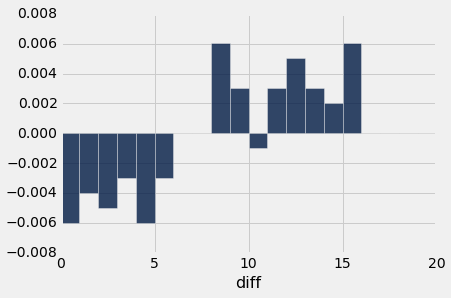

In [24]:
weight_dist.select(['bin','diff']).bar('bin')

In [25]:
weight.stats(summary_ops)

statistic,NoSmoke,Smoke
min,48.9879,39.0089
firstQtile,69.1728,63.8431
median,79.9456,74.3891
mean,81.8212,75.3938
thirdQtile,69.1728,63.8431
max,137.212,134.263
sum,16364.2,15078.8


In [33]:
np.mean(weight['NoSmoke'])-np.mean(weight['Smoke'])

6.4273976500000032

Is the difference observed between these samples representative of the larger population?

In [26]:
combined = Table([np.append(nosmoker_sample['weight'],smoker_sample['weight'])],['all'])

In [34]:
# permutation test, split the combined into two random groups, do the comparison of those
def getdiff():
    A,B = combined.split(300)
    return (np.mean(A['all'])-np.mean(B['all']))

In [35]:
# Do the permutation many times and form the distribution of results
num_samples = 100
diff_samples = Table([[getdiff() for i in range(num_samples)]],['diffs']) 

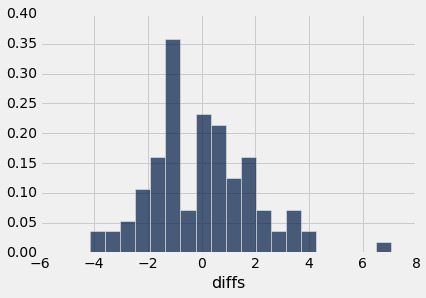

In [30]:
diff_samples.hist(bins=20, normed=True)